In [ ]:
# this is what Ed and I were doing when we first started playing around with 
# neural nets at the end of 2018
# https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/waveforms/nonspin/train_amplitude
# https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/waveforms/nonspin/network_utils.py

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import multiprocessing as mp
import functools

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [4]:
import wispy.lalutils
import wispy.model_utils
import wispy.callbacks

In [5]:
import lalsimulation as lalsim

In [6]:
import pugna.layers
import pugna.activations

# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
def build_and_fit_model(
    x,
    y,
    batch_size=None,
    nscales=1,
    epochs=1000,
    units=300,
    lr=1e-3,
    activation='srelu',
    validation_data=None,
    validation_freq=1,
    scale_name='linear',
    use_mscale=False,
    amsgrad=False
):
    if batch_size is None:
        batch_size = x.shape[0]

    input_shape = x.shape[1]
    output_shape = y.shape[1]
  
    loss = 'mae'
    metrics = ['mse']

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))
    if use_mscale:
        model.add(pugna.layers.Mscale(units, nscales, scale_name=scale_name))
    else:
        model.add(tf.keras.layers.Dense(units))
    if activation == 'srelu':
        model.add(tf.keras.layers.Activation(pugna.activations.sReLU))
    elif activation == 's2relu':
        model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
    elif activation == 'relu':
        model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
    elif activation == 'tanh':
        model.add(tf.keras.layers.Activation(tf.keras.activations.tanh))

    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(units, activation=activation))
#     model.add(tf.keras.layers.Dense(units, activation=activation))
#     model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(output_shape, activation="linear"))

#     optimizer = tf.keras.optimizers.Adam(lr)
#     optimizer = tf.keras.optimizers.Adam(lr, amsgrad=amsgrad)
#     optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipnorm=0.5)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipvalue=5.0)
    #optimizer = tf.keras.optimizers.Nadam(lr)
    # optimizer = tf.keras.optimizers.SGD(lr)
    
    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        optimizer = tf.keras.optimizers.Adam(learning_rate_fn, amsgrad=amsgrad)
    else:
        optimizer = tf.keras.optimizers.Adam(lr, amsgrad=amsgrad)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)
    
    threshold_callback = wispy.callbacks.ThresholdCallback(1e-9)
    callbacks.append(threshold_callback)

    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=callbacks, verbose=0, validation_freq=validation_freq)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

# try a 2D parameter space

In [9]:
def gen_data_2d_q_time(q_min, q_max, q_num, M=100, nproc=1):
    
    q_arr = np.linspace(q_min, q_max, q_num)

    ps = []
    for q in q_arr:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        ps.append(wispy.lalutils.gen_td_wf_params(m1=m1, m2=m2, approximant=lalsim.SEOBNRv4_opt, f_min=5, distance=1e6))
    
    times = []
    amp = []
    phase = []

#     for p in ps:
#         _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
#         times.append(_times)
#         amp.append(_amp)
#         phase.append(_phase)    
    
#     def mapable(p):
#         _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
#         return (_times, _amp, _phase)
    
    func = functools.partial(wispy.lalutils.gen_td_wf, t_max=40, t_min=-2000)
    
    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)
#     print(len(returned))
#     print(len(returned[0]))
#     print(returned[0])
    for i in range(len(returned)):
        times.append(returned[i][0])
        amp.append(returned[i][1])
        phase.append(returned[i][2])   


        
    # find common times and interpolate data onto common time grid
    dt_M = 0.5
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    print(f"common_tmin = {common_tmin}")
    print(f"common_tmax = {common_tmax}")

    common_times = np.arange(common_tmin, common_tmax, dt_M)

    ntimes = len(common_times)
    print(f"ntimes = {ntimes}")
    
    n_cases = len(ps)

    amps = np.zeros(shape=(n_cases, ntimes))
    phases = np.zeros(shape=(n_cases, ntimes))

    for i in range(n_cases):
        amps[i] = IUS(times[i], amp[i])(common_times)
        phases[i] = IUS(times[i], phase[i])(common_times)
                
    return common_times, amps, phases, q_arr

In [10]:
def gen_data_2d_s1x_time(s1x_min, s1x_max, s1x_num, q=1, M=100, nproc=1, t_min=-500):
    
    s1x_arr = np.linspace(s1x_min, s1x_max, s1x_num)

    ps = []
    for s1x in s1x_arr:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        ps.append(wispy.lalutils.gen_td_wf_params(m1=m1, m2=m2, S1x=s1x, approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6))
    
    times = []
    amp = []
    phase = []

#     for p in ps:
#         _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
#         times.append(_times)
#         amp.append(_amp)
#         phase.append(_phase)    
    
#     def mapable(p):
#         _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
#         return (_times, _amp, _phase)
    
    func = functools.partial(wispy.lalutils.gen_td_wf, t_max=40, t_min=t_min)
    
    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)
#     print(len(returned))
#     print(len(returned[0]))
#     print(returned[0])
    for i in range(len(returned)):
        times.append(returned[i][0])
        amp.append(returned[i][1])
        phase.append(returned[i][2])   


        
    # find common times and interpolate data onto common time grid
    dt_M = 0.5
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    print(f"common_tmin = {common_tmin}")
    print(f"common_tmax = {common_tmax}")

    common_times = np.arange(common_tmin, common_tmax, dt_M)

    ntimes = len(common_times)
    print(f"ntimes = {ntimes}")
    
    n_cases = len(ps)

    amps = np.zeros(shape=(n_cases, ntimes))
    phases = np.zeros(shape=(n_cases, ntimes))

    for i in range(n_cases):
        amps[i] = IUS(times[i], amp[i])(common_times)
        phases[i] = IUS(times[i], phase[i])(common_times)
                
    return common_times, amps, phases, s1x_arr

In [11]:
%%time
# common_times, amps, phases, q_arr = gen_data_2d_q_time(q_min=1, q_max=2, q_num=10, M=100, nproc=2)
common_times, amps, phases, q_arr = gen_data_2d_s1x_time(s1x_min=0, s1x_max=0.99, s1x_num=3, q=3, M=100, nproc=4, t_min=-500)

common_tmin = -499.65485542229254
common_tmax = 39.57700617851138
ntimes = 1079
CPU times: user 13.2 ms, sys: 23.7 ms, total: 36.9 ms
Wall time: 3.55 s


In [12]:
%%time
# _, amps_val, phases_val, q_arr_val = gen_data_2d_q_time(q_min=1.1, q_max=2.1, q_num=8, M=100, nproc=2)
_, amps_val, phases_val, q_arr_val = gen_data_2d_s1x_time(s1x_min=0.1, s1x_max=0.98, s1x_num=2, q=3, M=100, nproc=4, t_min=-500)

common_tmin = -499.5972817208031
common_tmax = 39.52348917916639
ntimes = 1079
CPU times: user 12.1 ms, sys: 20.6 ms, total: 32.7 ms
Wall time: 3.44 s


In [13]:
q_arr

array([0.   , 0.495, 0.99 ])

In [14]:
q_arr_val

array([0.1 , 0.98])

In [15]:
common_times

array([-499.65485542, -499.15485542, -498.65485542, ...,   38.34514458,
         38.84514458,   39.34514458])

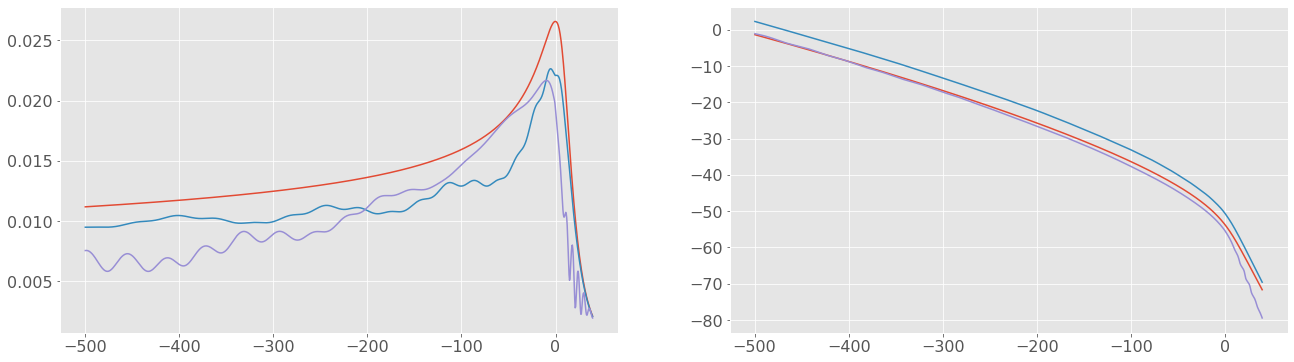

In [15]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for y in amps:
    plt.plot(common_times, y)
    
# plt.xlim(-100, 40)


plt.subplot(1, 2, 2)
for y in phases:
    plt.plot(common_times, y)

In [16]:
# the features will be (q, t)

In [17]:
# X = np.outer(q_arr, common_times)

In [18]:
def convert_input_for_ann(times, q):
    times = np.atleast_1d(times)
    q = np.atleast_1d(q)
    XX, YY = np.meshgrid(times, q)
    X = np.stack((XX.ravel(), YY.ravel()), axis=1) #axis=1 is same as column_stack
    
    return X

In [19]:
def compute_pre_process(ys):
    ys = ys.copy()
    ys_mean = np.mean(ys, axis=0)[np.newaxis, :] # mean waveform
    ys -= ys_mean
    ys_max = np.max(ys)
#     ys /= ys_max
    
    return ys_mean, ys_max

In [20]:
def apply_pre_process_forward(ys, y_mean ,y_max):
    ys = ys.copy()
    ys -= y_mean
    ys /= y_max
    
    return ys

In [21]:
def apply_pre_process_reverse(ys, y_mean ,y_max):
    ys = ys.copy()
    ys *= y_max
    ys += y_mean
    
    return ys

In [22]:
y_mean, y_max = compute_pre_process(amps)

In [23]:
amps_prime = apply_pre_process_forward(amps, y_mean, y_max)

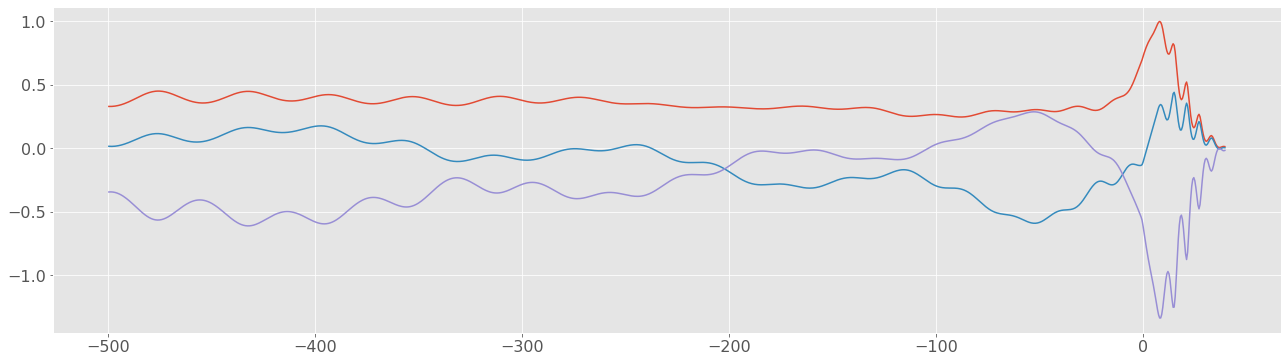

In [24]:
plt.figure(figsize=(22, 6))
for y in amps_prime:
    plt.plot(common_times, y)
    
# plt.xlim(-100, 40)

In [25]:
amps_prime_reverse = apply_pre_process_reverse(amps_prime, y_mean, y_max)

In [26]:
np.testing.assert_array_almost_equal(amps, amps_prime_reverse)

In [27]:
amps.shape

(3, 1079)

In [28]:
y_mean.shape

(1, 1079)

In [29]:
y_max

0.005376569496458091

In [32]:
common_times.shape

(1079,)

In [123]:
# scale times to between -1, 1
# times_scaler = MinMaxScaler(feature_range=(-1,1))
times_scaler = MinMaxScaler(feature_range=(0,1))
common_times_scaled = times_scaler.fit_transform(common_times[:, np.newaxis])[:,0]

In [124]:
common_times_scaled

array([0.00000000e+00, 9.27643785e-04, 1.85528757e-03, ...,
       9.98144712e-01, 9.99072356e-01, 1.00000000e+00])

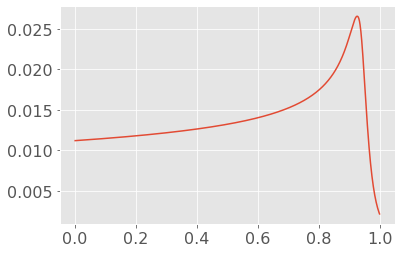

In [125]:
plt.figure()
plt.plot(common_times_scaled, amps[0])

In [126]:
np.testing.assert_array_almost_equal(common_times, times_scaler.inverse_transform(common_times_scaled[:,np.newaxis])[:,0])

In [127]:
# X = convert_input_for_ann(common_times, q_arr)
X = convert_input_for_ann(common_times_scaled, q_arr)

In [128]:
X.shape

(3237, 2)

In [129]:
y = amps_prime.ravel().reshape(-1, 1)

In [130]:
y.shape

(3237, 1)

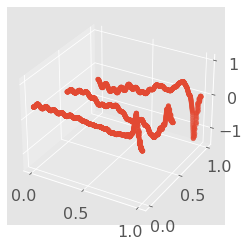

In [131]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0], X[:,1], y[:,0])

In [132]:
# XX_val, YY_val = np.meshgrid(common_times, q_arr_val)
# X_val = np.stack((XX_val.ravel(), YY_val.ravel()), axis=1) #axis=1 is same as column_stack

# X_val = convert_input_for_ann(common_times, q_arr_val)
X_val = convert_input_for_ann(common_times_scaled, q_arr_val)

amps_val_prime = apply_pre_process_forward(amps_val, y_mean, y_max)


y_val = amps_val_prime.ravel().reshape(-1, 1)


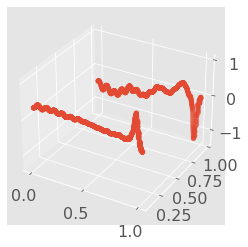

In [133]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_val[:,0], X_val[:,1], y_val[:,0])

In [134]:
# training data X and y

print(f"num cases: {q_arr.shape}")

print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

num cases: (3,)
X.shape = (3237, 2)
y.shape = (3237, 1)


In [135]:
# validation data X and y

print(f"num cases: {q_arr_val.shape}")

print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")

num cases: (2,)
X_val.shape = (2158, 2)
y_val.shape = (2158, 1)


# fitting data

In [136]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [137]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)
    
    threshold_callback = wispy.callbacks.ThresholdCallback(1e-9)
    callbacks.append(threshold_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 25min 45s, sys: 13min 15s, total: 39min
Wall time: 8min 47s


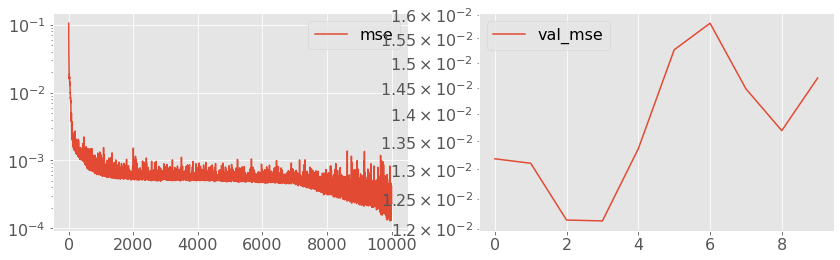

In [145]:
%%time
amp_history, model_amp = build_and_fit_model(
    x=X,
    y=y,
    batch_size=1000,
    lr=1e-3,
    validation_data=(X_val, y_val),
    validation_freq=1000,
    activation='s2relu', epochs=10000, nscales=4, units=300, scale_name='base2', use_mscale=True,
    amsgrad=False
)

In [140]:
model_amp.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_15 (Mscale)           (None, 300)               900       
_________________________________________________________________
activation_9 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_22 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 301       
Total params: 181,801
Trainable params: 181,801
Non-trainable params: 0
_________________________________________________________________


In [112]:
# model = build_decoder(input_shape=X.shape[1], output_shape=y.shape[1], units = [64, 1000], acts = ['relu', 'relu'])
# model = build_decoder(input_shape=X.shape[1], output_shape=y.shape[1], units = [64, 128, 128], acts = ['relu', 'relu', 'relu'])

In [113]:
# model.summary()

In [114]:
# %%time
# amp_history, model_amp = initial_fit(
#     model,
#     x=X,
#     y=y,
#     validation_data=(X_val, y_val),
#     epochs=1000,
#     batch_size=10,
#     validation_freq=100,
#     lr=1e-3)

In [146]:
def compare_models(model, q_arr, y, index, times=common_times, compare_in_model_space=False):
    times = times.copy()

    y=y.copy()
    
    if compare_in_model_space:
        y = apply_pre_process_forward(y, y_mean, y_max)
    y = y[index]
    
    X = convert_input_for_ann(times, q_arr[index])
    yhat = model.predict(X).T
#     print(yhat.shape)
#     # reverse processing
    if not compare_in_model_space:
        yhat = apply_pre_process_reverse(yhat, y_mean, y_max)
    yhat = yhat[0]
#     yhat = yhat[index]

    if not compare_in_model_space:
        times = times_scaler.inverse_transform(times[:,np.newaxis])[:,0]
    


    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat', ls='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-100, 20)
#     plt.ylim(-70, -40)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(q_arr[index], 3)}"
    plt.suptitle(title)

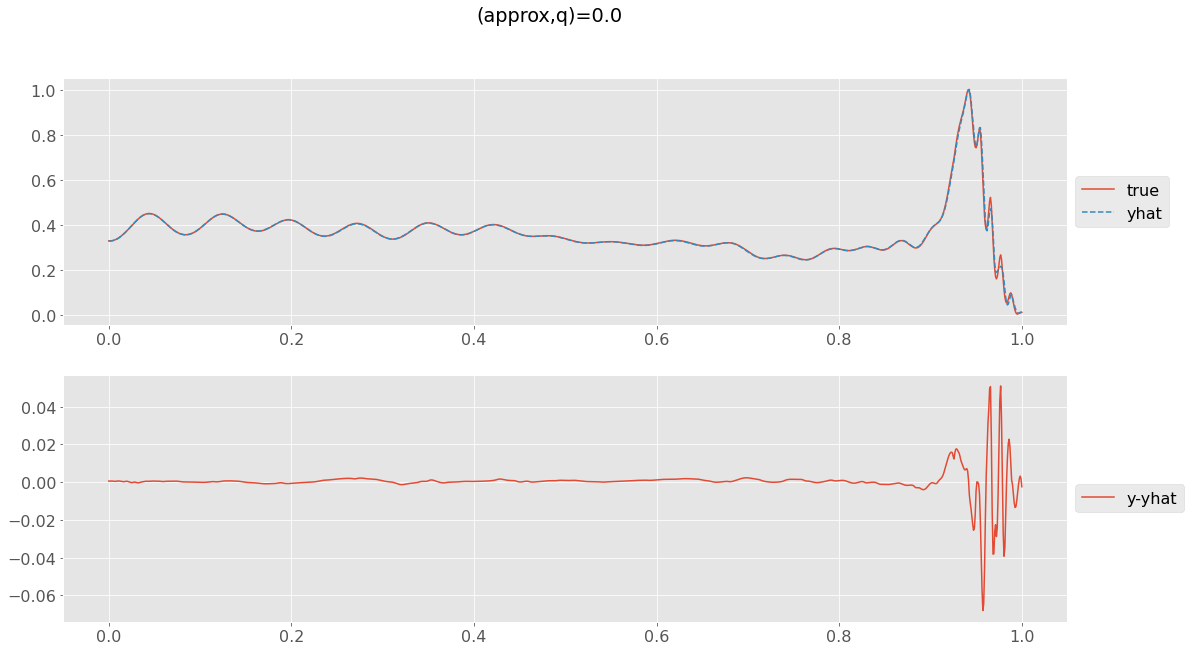

In [147]:
compare_models(model=model_amp, q_arr=q_arr, y=amps, index=0, compare_in_model_space=True, times=common_times_scaled)

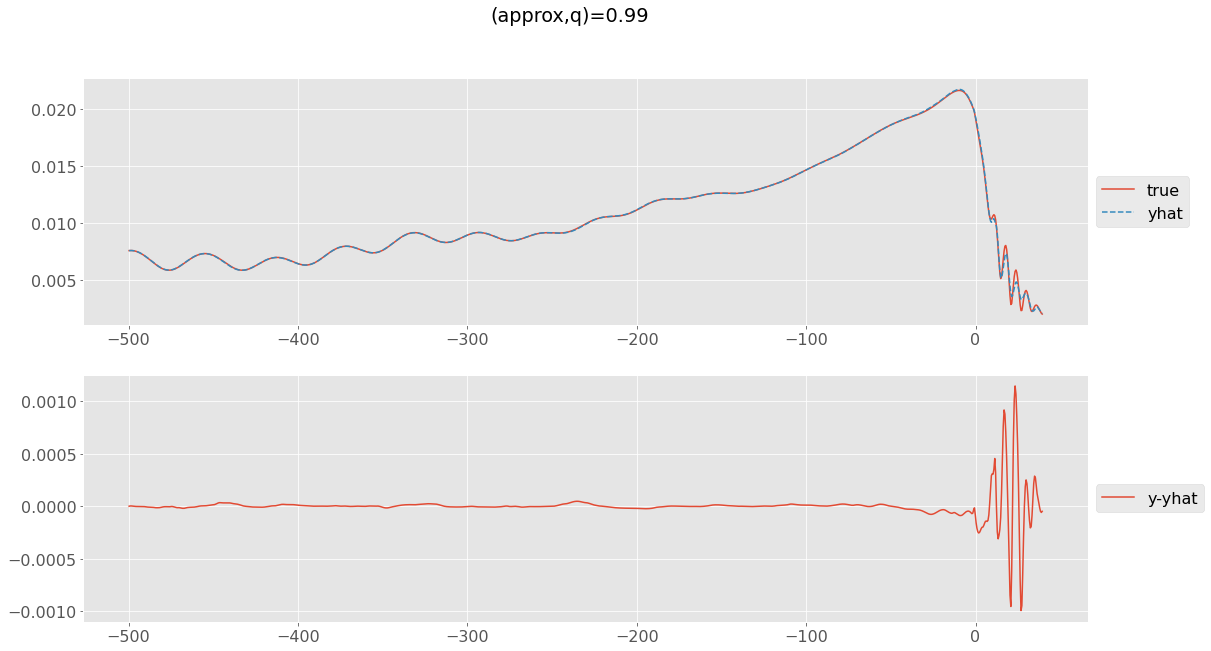

In [148]:
compare_models(model=model_amp, q_arr=q_arr, y=amps, index=2, compare_in_model_space=False, times=common_times_scaled)

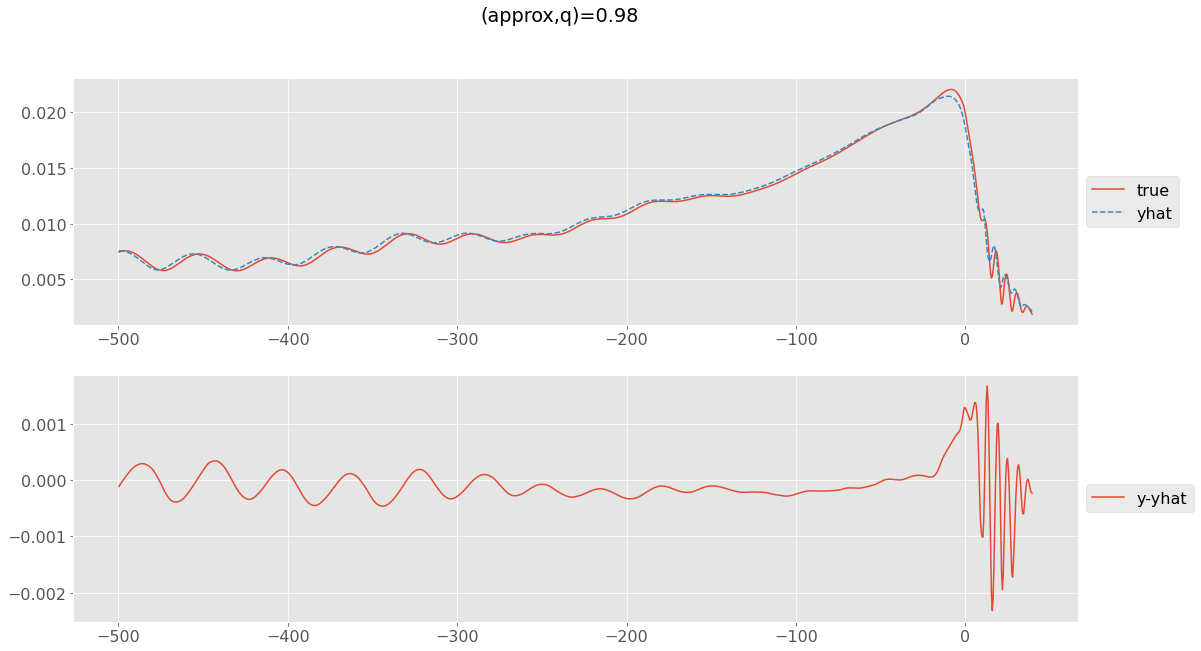

In [149]:
compare_models(model=model_amp, q_arr=q_arr_val, y=amps_val, index=-1, compare_in_model_space=False, times=common_times_scaled)

In [313]:
model_amp.predict(X).shape

(10790, 1)

In [314]:
X.shape

(10790, 2)

In [315]:
common_times.min()

-499.50900219745535

In [316]:
common_times.max()

39.490997802544655

In [317]:
times_prime = np.linspace(-600, 50, 30)
XX_prime = convert_input_for_ann(times_prime, 1)

yhat_prime = model_amp.predict(XX_prime).T

print(yhat_prime.shape)

# need to interpolate mean waveform onto new grid
yhat_prime = apply_pre_process_reverse(yhat_prime, IUS(common_times, y_mean)(times_prime)[np.newaxis, :], y_max)

(1, 30)


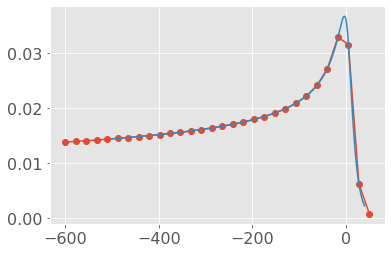

In [318]:
plt.figure()
plt.plot(times_prime, yhat_prime[0], 'o-')
plt.plot(common_times, amps[0])